In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/dataset_splits (AMD).zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset_splits (AMD)/val/masks/Farsiu_Ophthalmology_2013_AMD_Subject_1201_slice_069_vis.png  
  inflating: /content/__MACOSX/dataset_splits (AMD)/val/masks/._Farsiu_Ophthalmology_2013_AMD_Subject_1201_slice_069_vis.png  
  inflating: /content/dataset_splits (AMD)/val/masks/Farsiu_Ophthalmology_2013_AMD_Subject_1169_slice_014_vis.png  
  inflating: /content/__MACOSX/dataset_splits (AMD)/val/masks/._Farsiu_Ophthalmology_2013_AMD_Subject_1169_slice_014_vis.png  
  inflating: /content/dataset_splits (AMD)/val/masks/Farsiu_Ophthalmology_2013_AMD_Subject_1150_slice_021.png  
  inflating: /content/__MACOSX/dataset_splits (AMD)/val/masks/._Farsiu_Ophthalmology_2013_AMD_Subject_1150_slice_021.png  
  inflating: /content/dataset_splits (AMD)/val/masks/Farsiu_Ophthalmology_2013_AMD_Subject_1248_slice_030.png  
  inflating: /content/__MACOSX/dataset_splits (AMD)/val/masks/._Farsiu_Ophthalmology_2013_AMD_Subject_1248_slice_030

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import numpy as np
from tqdm import tqdm

# -------------------
# CONFIG
# -------------------
DATA_DIR = "/content/dataset_splits (AMD)"
NUM_CLASSES = 4        # background + 3 retinal layers
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEST_MODEL_PATH = "resnet_seg_best.pth"

print("Using device:", DEVICE)

# -------------------
# DATASET
# -------------------
class OCTDataset(Dataset):
    def __init__(self, root_dir):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        # All images
        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith(".png")])
        # Masks excluding vis.png
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith(".png") and "vis" not in f])
        # Only keep matching files
        self.files = [f for f in self.img_files if f in self.mask_files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        # Load image (grayscale) and convert to 3 channels
        img = np.array(Image.open(os.path.join(self.img_dir, img_name)).convert("L"))
        img = np.stack([img, img, img], axis=0)
        img = torch.tensor(img, dtype=torch.float32) / 255.0

        # Load mask
        mask = np.array(Image.open(os.path.join(self.mask_dir, img_name)).convert("L"))
        mask = torch.tensor(mask, dtype=torch.long)

        return img, mask

# Datasets and loaders
train_ds = OCTDataset(os.path.join(DATA_DIR, "train"))
val_ds   = OCTDataset(os.path.join(DATA_DIR, "val"))
test_ds  = OCTDataset(os.path.join(DATA_DIR, "test"))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# -------------------
# MODEL
# -------------------
class ResNetSeg(nn.Module):
    def __init__(self, num_classes=4, backbone="resnet34"):
        super().__init__()
        base = getattr(models, backbone)(weights="IMAGENET1K_V1")
        self.encoder = nn.Sequential(*list(base.children())[:-2])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ResNetSeg(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# -------------------
# DICE SCORE
# -------------------
def dice_score(pred, target, num_classes=4, smooth=1e-6):
    pred = torch.argmax(pred, dim=1)  # (B,H,W)
    dice = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice.append(((2*intersection + smooth) / (union + smooth)).cpu().item())
    return dice

# -------------------
# TRAIN / EVAL FUNCTIONS
# -------------------
def train_one_epoch(loader, model, optimizer, criterion):
    model.train()
    running_loss = 0
    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(loader, model, criterion):
    model.eval()
    running_loss = 0
    dice_sum = np.zeros(NUM_CLASSES)
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            dice = dice_score(outputs, masks)
            dice_sum += np.array(dice)
    avg_dice = dice_sum / len(loader)
    return running_loss / len(loader), avg_dice

# -------------------
# TRAIN LOOP
# -------------------
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(train_loader, model, optimizer, criterion)
    val_loss, val_dice = evaluate(val_loader, model, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    print(f"Val Dice per class: {val_dice}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("✅ Best model saved!")

# Save final model
torch.save(model.state_dict(), "resnet_seg_final.pth")

Using device: cuda
Train: 14254, Val: 3127, Test: 3133
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s]
100%|██████████| 1782/1782 [02:45<00:00, 10.76it/s]


Epoch 1/20, Train Loss=0.1851, Val Loss=0.0546
Val Dice per class: [0.98674101 0.9515216  0.61915566 0.99301446]
✅ Best model saved!


100%|██████████| 1782/1782 [02:46<00:00, 10.67it/s]


Epoch 2/20, Train Loss=0.0406, Val Loss=0.0456
Val Dice per class: [0.98679032 0.95854615 0.70232821 0.99446188]
✅ Best model saved!


100%|██████████| 1782/1782 [02:46<00:00, 10.67it/s]


Epoch 3/20, Train Loss=0.0345, Val Loss=0.0435
Val Dice per class: [0.99101606 0.96371392 0.69110559 0.99425895]
✅ Best model saved!


100%|██████████| 1782/1782 [02:46<00:00, 10.70it/s]


Epoch 4/20, Train Loss=0.0297, Val Loss=0.0422
Val Dice per class: [0.99074222 0.96594798 0.73324423 0.99500269]
✅ Best model saved!


100%|██████████| 1782/1782 [02:46<00:00, 10.67it/s]


Epoch 5/20, Train Loss=0.0267, Val Loss=0.0445
Val Dice per class: [0.99107361 0.96613345 0.73014788 0.99497148]


100%|██████████| 1782/1782 [02:47<00:00, 10.67it/s]


Epoch 6/20, Train Loss=0.0244, Val Loss=0.0442
Val Dice per class: [0.99098729 0.96584493 0.73340577 0.9949838 ]


100%|██████████| 1782/1782 [02:46<00:00, 10.69it/s]


Epoch 7/20, Train Loss=0.0226, Val Loss=0.0441
Val Dice per class: [0.99125424 0.96703947 0.74008684 0.99510666]


100%|██████████| 1782/1782 [02:46<00:00, 10.71it/s]


Epoch 8/20, Train Loss=0.0214, Val Loss=0.0497
Val Dice per class: [0.99145995 0.96711116 0.7407743  0.99509815]


100%|██████████| 1782/1782 [02:46<00:00, 10.70it/s]


Epoch 9/20, Train Loss=0.0201, Val Loss=0.0493
Val Dice per class: [0.99135968 0.96704239 0.74214542 0.99508126]


100%|██████████| 1782/1782 [02:46<00:00, 10.69it/s]


Epoch 10/20, Train Loss=0.0191, Val Loss=0.0496
Val Dice per class: [0.99172379 0.96827876 0.75060774 0.99513969]


100%|██████████| 1782/1782 [02:46<00:00, 10.70it/s]


Epoch 11/20, Train Loss=0.0182, Val Loss=0.0504
Val Dice per class: [0.99183273 0.96877822 0.75013533 0.99517261]


100%|██████████| 1782/1782 [02:46<00:00, 10.71it/s]


Epoch 12/20, Train Loss=0.0174, Val Loss=0.0537
Val Dice per class: [0.99191728 0.96891665 0.75046063 0.99518622]


100%|██████████| 1782/1782 [02:46<00:00, 10.69it/s]


Epoch 13/20, Train Loss=0.0167, Val Loss=0.0532
Val Dice per class: [0.99172836 0.9689615  0.75182909 0.99530425]


100%|██████████| 1782/1782 [02:46<00:00, 10.68it/s]


Epoch 14/20, Train Loss=0.0160, Val Loss=0.0553
Val Dice per class: [0.99202622 0.96959408 0.75583735 0.9953539 ]


100%|██████████| 1782/1782 [02:46<00:00, 10.69it/s]


Epoch 15/20, Train Loss=0.0154, Val Loss=0.0566
Val Dice per class: [0.99206084 0.96980348 0.7548962  0.99529612]


100%|██████████| 1782/1782 [02:46<00:00, 10.68it/s]


Epoch 16/20, Train Loss=0.0148, Val Loss=0.0599
Val Dice per class: [0.991832   0.96870191 0.74523131 0.99520453]


100%|██████████| 1782/1782 [02:46<00:00, 10.68it/s]


Epoch 17/20, Train Loss=0.0144, Val Loss=0.0616
Val Dice per class: [0.99200139 0.96929818 0.75333216 0.9951316 ]


100%|██████████| 1782/1782 [02:49<00:00, 10.50it/s]


Epoch 18/20, Train Loss=0.0141, Val Loss=0.0588
Val Dice per class: [0.99227291 0.9701472  0.76118913 0.99518487]


100%|██████████| 1782/1782 [02:47<00:00, 10.65it/s]


Epoch 19/20, Train Loss=0.0133, Val Loss=0.0616
Val Dice per class: [0.99227087 0.97012876 0.75713988 0.99520584]


100%|██████████| 1782/1782 [02:46<00:00, 10.69it/s]


Epoch 20/20, Train Loss=0.0131, Val Loss=0.0626
Val Dice per class: [0.99210098 0.9695825  0.75656475 0.99508123]


In [4]:
!pip install PyMaxflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.2/939.2 kB 24.3 MB/s eta 0:00:00


In [5]:
import os
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
from PIL import Image
from tqdm import tqdm
import maxflow  # PyMaxflow

# -------------------
# CONFIG
# -------------------
TEST_DIR = "/content/dataset_splits (AMD)/test"
PRED_DIR = "/content/resnet_predictions"
GC_DIR = "/content/resnet_graphcut_predictions"

NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "resnet_seg_best.pth"

os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(GC_DIR, exist_ok=True)

# -------------------
# DATASET
# -------------------
class OCTDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "masks")
        self.img_files = sorted([f for f in os.listdir(self.img_dir) if f.endswith(".png")])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith(".png") and "vis" not in f])
        self.files = [f for f in self.img_files if f in self.mask_files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, img_name)).convert("L"))
        img = np.stack([img, img, img], axis=0)
        img = torch.tensor(img, dtype=torch.float32) / 255.0
        mask = np.array(Image.open(os.path.join(self.mask_dir, img_name)).convert("L"))
        mask = torch.tensor(mask, dtype=torch.long)
        return img, mask, img_name

# -------------------
# MODEL
# -------------------
class ResNetSeg(nn.Module):
    def __init__(self, num_classes=4, backbone="resnet34"):
        super().__init__()
        base = getattr(models, backbone)(weights="IMAGENET1K_V1")
        self.encoder = nn.Sequential(*list(base.children())[:-2])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 2, stride=2), nn.ReLU(),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# -------------------
# GRAPH CUT (ALPHA-EXPANSION)
# -------------------
def graph_cut_alpha_expansion(probs, img_np, smooth_weight=10, max_iter=5):
    """
    Faster multiclass alpha-expansion using PyMaxflow.
    probs: (H, W, C) softmax probabilities
    img_np: (H, W) grayscale image
    """
    H, W, C = probs.shape
    labels = np.argmax(probs, axis=2).astype(np.uint8)

    for iteration in range(max_iter):
        old_labels = labels.copy()
        for alpha in range(C):
            g = maxflow.Graph[float]()
            nodes = g.add_nodes(H * W)

            # Unary: cost to stay vs switch to alpha
            cost_current = -np.log(probs[np.arange(H)[:, None], np.arange(W), labels] + 1e-8)
            cost_alpha = -np.log(probs[:, :, alpha] + 1e-8)
            for i in range(H):
                for j in range(W):
                    idx = i * W + j
                    g.add_tedge(nodes[idx], cost_alpha[i, j], cost_current[i, j])

            # Pairwise (right & bottom neighbors)
            right_diff = np.zeros((H, W-1))
            bottom_diff = np.zeros((H-1, W))
            right_diff = np.exp(-np.abs(img_np[:, :-1] - img_np[:, 1:]) / 50.0) * smooth_weight
            bottom_diff = np.exp(-np.abs(img_np[:-1, :] - img_np[1:, :]) / 50.0) * smooth_weight

            for i in range(H):
                for j in range(W):
                    idx = i * W + j
                    if j < W - 1:
                        if labels[i, j] != labels[i, j+1]:
                            g.add_edge(nodes[idx], nodes[i*W + (j+1)], right_diff[i,j], right_diff[i,j])
                    if i < H - 1:
                        if labels[i, j] != labels[i+1, j]:
                            g.add_edge(nodes[idx], nodes[(i+1)*W + j], bottom_diff[i,j], bottom_diff[i,j])

            g.maxflow()
            for i in range(H):
                for j in range(W):
                    idx = i * W + j
                    if g.get_segment(nodes[idx]) == 1:
                        labels[i,j] = alpha

        if np.array_equal(labels, old_labels):
            break

    return labels

# -------------------
# INFERENCE + GRAPH CUT
# -------------------
test_ds = OCTDataset(TEST_DIR)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

model = ResNetSeg(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

with torch.no_grad():
    for imgs, masks, img_names in tqdm(test_loader, desc="CNN + Graph Cut"):
        imgs = imgs.to(DEVICE)

        outputs = model(imgs).squeeze(0)
        probs = torch.softmax(outputs, dim=0).permute(1, 2, 0).cpu().numpy()

        # CNN-only
        pred_cnn = np.argmax(probs, axis=-1).astype(np.uint8)
        Image.fromarray(pred_cnn).save(os.path.join(PRED_DIR, img_names[0]))

        # Grayscale input for graph cut
        img_np = (imgs.squeeze(0).cpu().numpy()[0] * 255).astype(np.uint8)

        # Graph Cut refinement
        refined_mask = graph_cut_alpha_expansion(probs, img_np, smooth_weight=10, max_iter=5)
        Image.fromarray(refined_mask.astype(np.uint8)).save(os.path.join(GC_DIR, img_names[0]))

print("✅ CNN + Graph Cut inference completed!")


CNN + Graph Cut: 100%|██████████| 3133/3133 [22:54<00:00,  2.28it/s]

✅ CNN + Graph Cut inference completed!


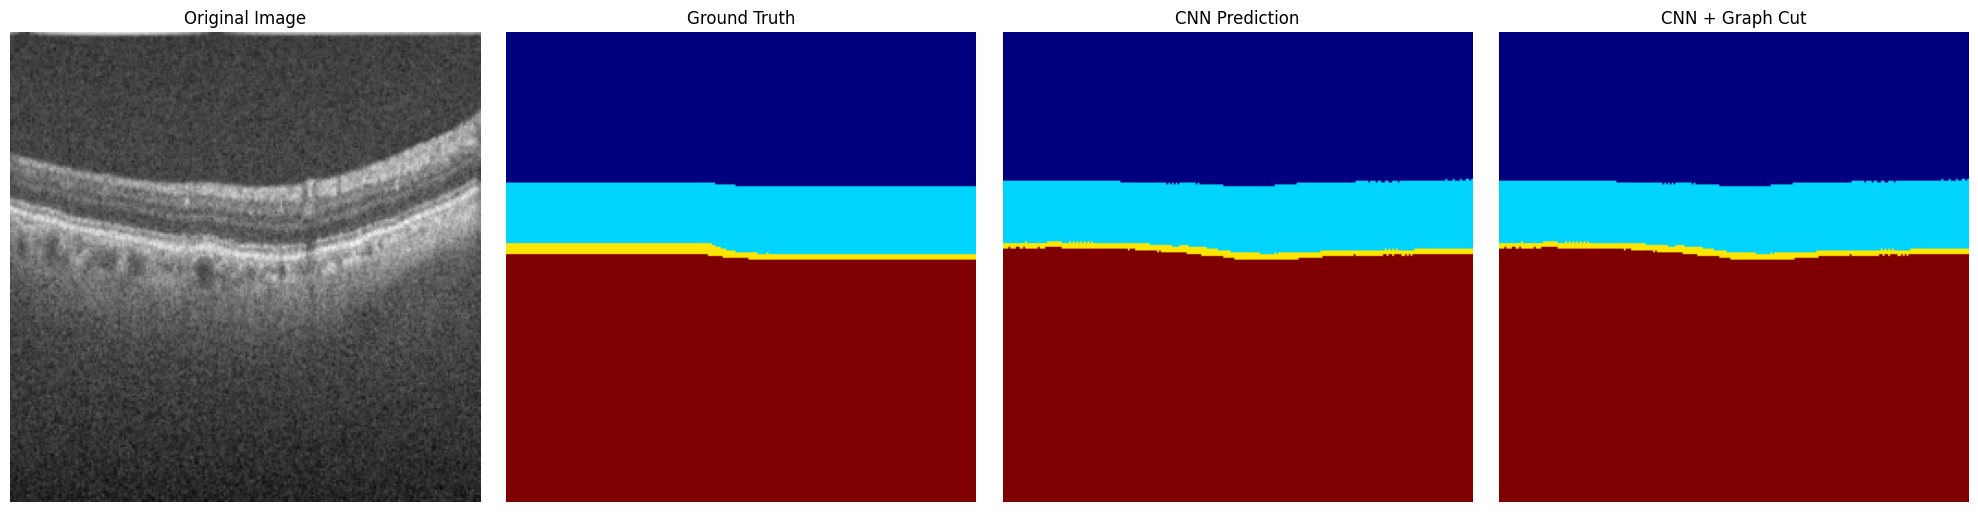

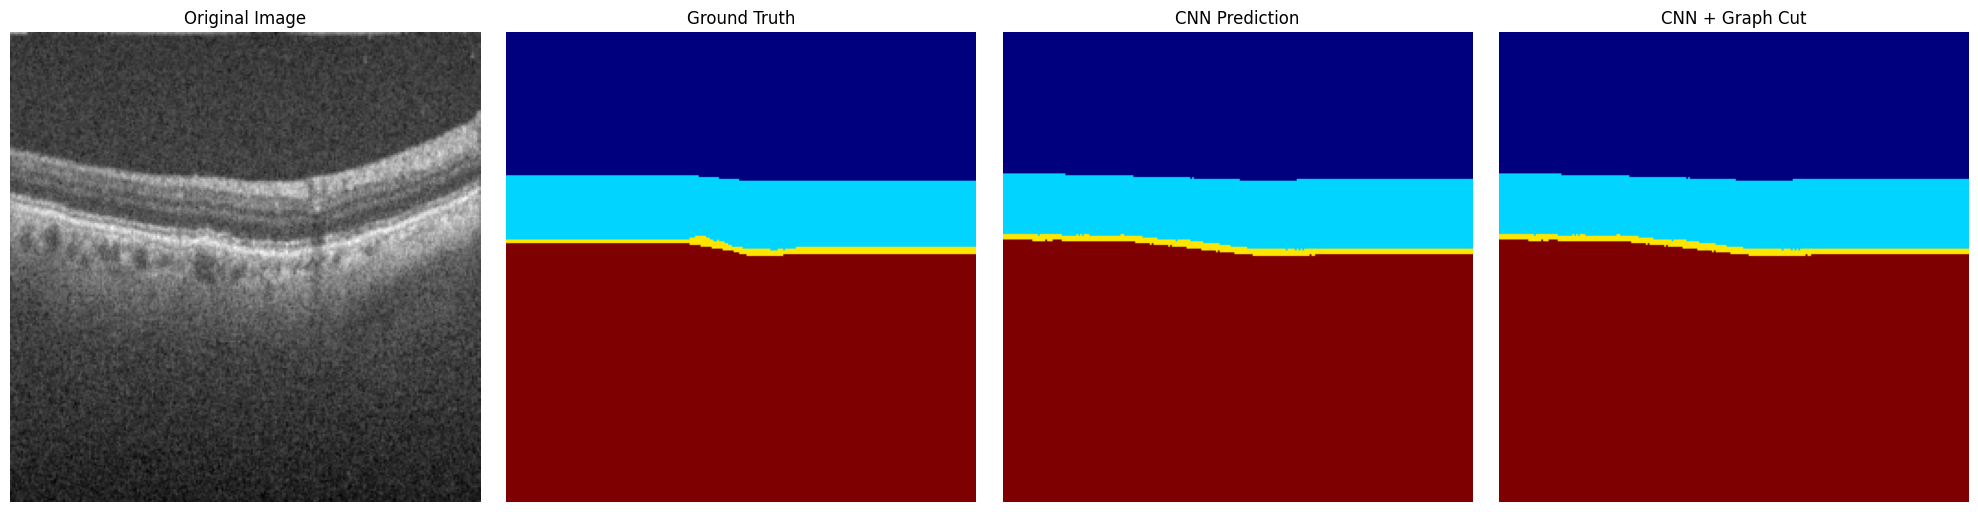

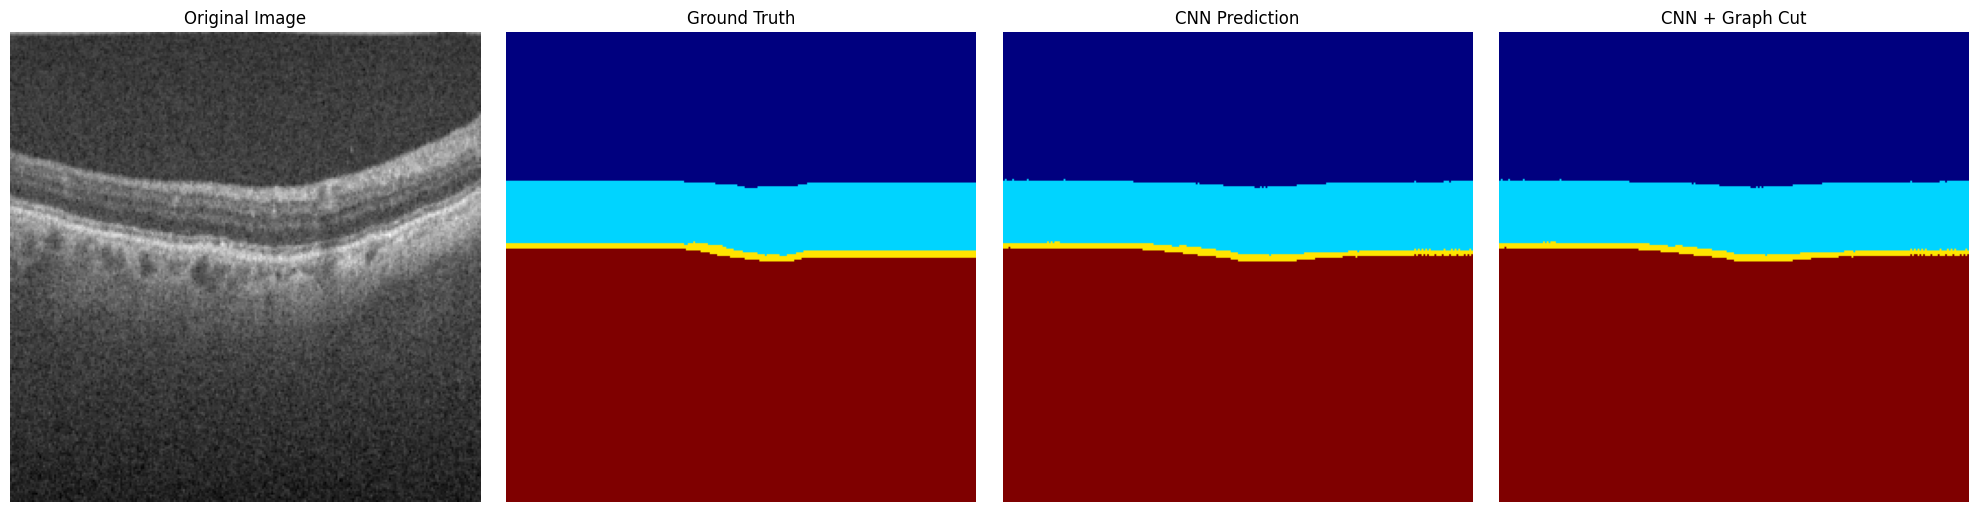

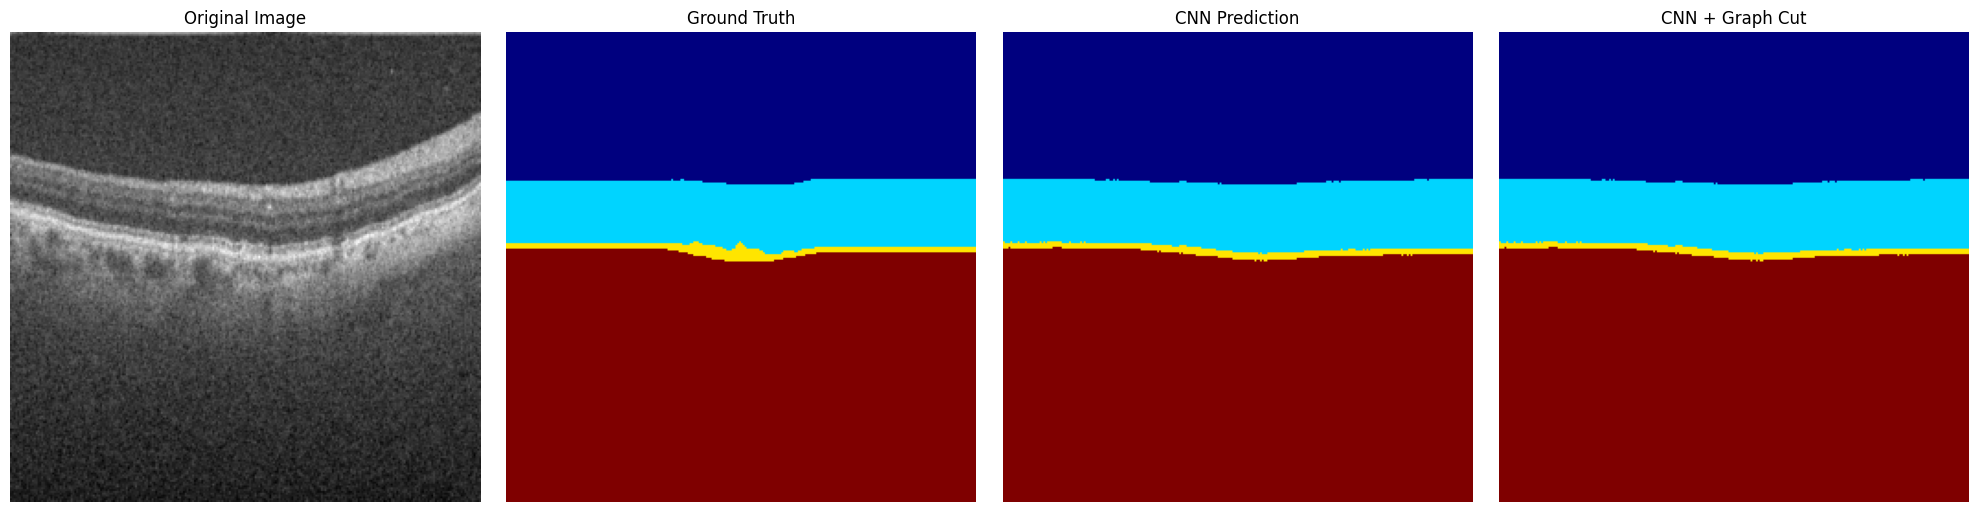

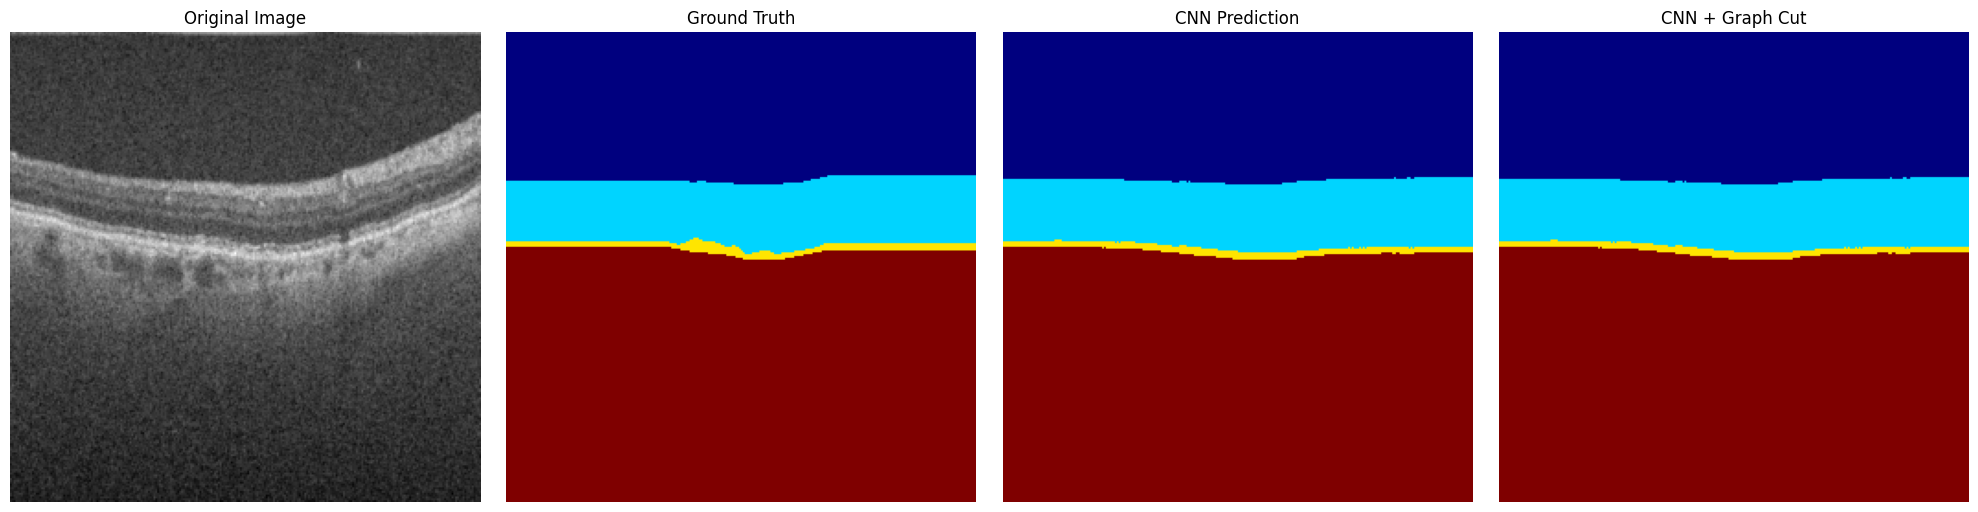

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# -------------------
# CONFIG
# -------------------
TEST_DIR = "/content/dataset_splits (AMD)/test"
PRED_DIR = "/content/resnet_predictions"
GC_DIR   = "/content/resnet_graphcut_predictions"

NUM_IMAGES = 5  # Number of images to visualize

# Get list of image filenames
img_files = sorted([f for f in os.listdir(os.path.join(TEST_DIR, "images")) if f.endswith(".png")])[:NUM_IMAGES]

# -------------------
# VISUALIZATION
# -------------------
for img_name in img_files:
    img = np.array(Image.open(os.path.join(TEST_DIR, "images", img_name)).convert("L"))
    gt_mask = np.array(Image.open(os.path.join(TEST_DIR, "masks", img_name)).convert("L"))
    cnn_mask = np.array(Image.open(os.path.join(PRED_DIR, img_name))).astype(np.uint8)
    gc_mask = np.array(Image.open(os.path.join(GC_DIR, img_name))).astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(img, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(gt_mask, cmap="jet", vmin=0, vmax=3)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(cnn_mask, cmap="jet", vmin=0, vmax=3)
    axes[2].set_title("CNN Prediction")
    axes[2].axis("off")

    axes[3].imshow(gc_mask, cmap="jet", vmin=0, vmax=3)
    axes[3].set_title("CNN + Graph Cut")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()


In [7]:
import os
import numpy as np
from PIL import Image

# -------------------
# CONFIG
# -------------------
TEST_DIR = "/content/dataset_splits (AMD)/test"
PRED_DIR = "/content/resnet_predictions"
GC_DIR   = "/content/resnet_graphcut_predictions"

NUM_CLASSES = 4

# -------------------
# METRIC FUNCTIONS
# -------------------
def dice_coefficient(y_true, y_pred, num_classes=4):
    dice_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        intersection = np.sum(y_true_c * y_pred_c)
        union = np.sum(y_true_c) + np.sum(y_pred_c)
        dice = (2 * intersection) / (union + 1e-8)
        dice_per_class.append(dice)
    return dice_per_class, np.mean(dice_per_class)

def iou_score(y_true, y_pred, num_classes=4):
    iou_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        intersection = np.sum(y_true_c * y_pred_c)
        union = np.sum((y_true_c + y_pred_c) > 0)
        iou = intersection / (union + 1e-8)
        iou_per_class.append(iou)
    return iou_per_class, np.mean(iou_per_class)

def precision_score(y_true, y_pred, num_classes=4):
    precision_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        tp = np.sum(y_true_c * y_pred_c)
        fp = np.sum((y_pred_c == 1) & (y_true_c == 0))
        precision = tp / (tp + fp + 1e-8)
        precision_per_class.append(precision)
    return precision_per_class, np.mean(precision_per_class)

def recall_score(y_true, y_pred, num_classes=4):
    recall_per_class = []
    for c in range(num_classes):
        y_true_c = (y_true == c).astype(np.uint8)
        y_pred_c = (y_pred == c).astype(np.uint8)
        tp = np.sum(y_true_c * y_pred_c)
        fn = np.sum((y_true_c == 1) & (y_pred_c == 0))
        recall = tp / (tp + fn + 1e-8)
        recall_per_class.append(recall)
    return recall_per_class, np.mean(recall_per_class)

# -------------------
# LOAD FILES
# -------------------
img_files = sorted([f for f in os.listdir(os.path.join(TEST_DIR, "images")) if f.endswith(".png")])

# Store results
dice_cnn_all, dice_gc_all = [], []
iou_cnn_all, iou_gc_all = [], []
precision_cnn_all, precision_gc_all = [], []
recall_cnn_all, recall_gc_all = [], []

for img_name in img_files:
    gt_mask = np.array(Image.open(os.path.join(TEST_DIR, "masks", img_name)).convert("L"))
    cnn_mask = np.array(Image.open(os.path.join(PRED_DIR, img_name))).astype(np.uint8)
    gc_mask  = np.array(Image.open(os.path.join(GC_DIR, img_name))).astype(np.uint8)

    # Dice
    dice_cnn, _ = dice_coefficient(gt_mask, cnn_mask, NUM_CLASSES)
    dice_gc, _  = dice_coefficient(gt_mask, gc_mask, NUM_CLASSES)
    dice_cnn_all.append(dice_cnn)
    dice_gc_all.append(dice_gc)

    # IoU
    iou_cnn, _ = iou_score(gt_mask, cnn_mask, NUM_CLASSES)
    iou_gc, _  = iou_score(gt_mask, gc_mask, NUM_CLASSES)
    iou_cnn_all.append(iou_cnn)
    iou_gc_all.append(iou_gc)

    # Precision
    precision_cnn, _ = precision_score(gt_mask, cnn_mask, NUM_CLASSES)
    precision_gc, _  = precision_score(gt_mask, gc_mask, NUM_CLASSES)
    precision_cnn_all.append(precision_cnn)
    precision_gc_all.append(precision_gc)

    # Recall
    recall_cnn, _ = recall_score(gt_mask, cnn_mask, NUM_CLASSES)
    recall_gc, _  = recall_score(gt_mask, gc_mask, NUM_CLASSES)
    recall_cnn_all.append(recall_cnn)
    recall_gc_all.append(recall_gc)

# Convert to numpy arrays for averaging
dice_cnn_all = np.array(dice_cnn_all)
dice_gc_all = np.array(dice_gc_all)
iou_cnn_all = np.array(iou_cnn_all)
iou_gc_all = np.array(iou_gc_all)
precision_cnn_all = np.array(precision_cnn_all)
precision_gc_all = np.array(precision_gc_all)
recall_cnn_all = np.array(recall_cnn_all)
recall_gc_all = np.array(recall_gc_all)

# -------------------
# PRINT RESULTS
# -------------------
for c in range(NUM_CLASSES):
    print(f"Class {c}:")
    print(f"  Dice       - CNN: {dice_cnn_all[:,c].mean():.4f}, CNN+GC: {dice_gc_all[:,c].mean():.4f}")
    print(f"  IoU        - CNN: {iou_cnn_all[:,c].mean():.4f}, CNN+GC: {iou_gc_all[:,c].mean():.4f}")
    print(f"  Precision  - CNN: {precision_cnn_all[:,c].mean():.4f}, CNN+GC: {precision_gc_all[:,c].mean():.4f}")
    print(f"  Recall     - CNN: {recall_cnn_all[:,c].mean():.4f}, CNN+GC: {recall_gc_all[:,c].mean():.4f}")

print("\nMean across all classes:")
print(f"  Dice      - CNN: {dice_cnn_all.mean():.4f}, CNN+GC: {dice_gc_all.mean():.4f}")
print(f"  IoU       - CNN: {iou_cnn_all.mean():.4f}, CNN+GC: {iou_gc_all.mean():.4f}")
print(f"  Precision - CNN: {precision_cnn_all.mean():.4f}, CNN+GC: {precision_gc_all.mean():.4f}")
print(f"  Recall    - CNN: {recall_cnn_all.mean():.4f}, CNN+GC: {recall_gc_all.mean():.4f}")

Class 0:
  Dice       - CNN: 0.9904, CNN+GC: 0.9904
  IoU        - CNN: 0.9811, CNN+GC: 0.9811
  Precision  - CNN: 0.9906, CNN+GC: 0.9906
  Recall     - CNN: 0.9904, CNN+GC: 0.9904
Class 1:
  Dice       - CNN: 0.9679, CNN+GC: 0.9679
  IoU        - CNN: 0.9389, CNN+GC: 0.9389
  Precision  - CNN: 0.9669, CNN+GC: 0.9669
  Recall     - CNN: 0.9691, CNN+GC: 0.9691
Class 2:
  Dice       - CNN: 0.7420, CNN+GC: 0.7420
  IoU        - CNN: 0.6064, CNN+GC: 0.6064
  Precision  - CNN: 0.7507, CNN+GC: 0.7507
  Recall     - CNN: 0.7389, CNN+GC: 0.7389
Class 3:
  Dice       - CNN: 0.9950, CNN+GC: 0.9950
  IoU        - CNN: 0.9902, CNN+GC: 0.9902
  Precision  - CNN: 0.9947, CNN+GC: 0.9947
  Recall     - CNN: 0.9955, CNN+GC: 0.9955

Mean across all classes:
  Dice      - CNN: 0.9238, CNN+GC: 0.9238
  IoU       - CNN: 0.8792, CNN+GC: 0.8792
  Precision - CNN: 0.9257, CNN+GC: 0.9257
  Recall    - CNN: 0.9235, CNN+GC: 0.9235
